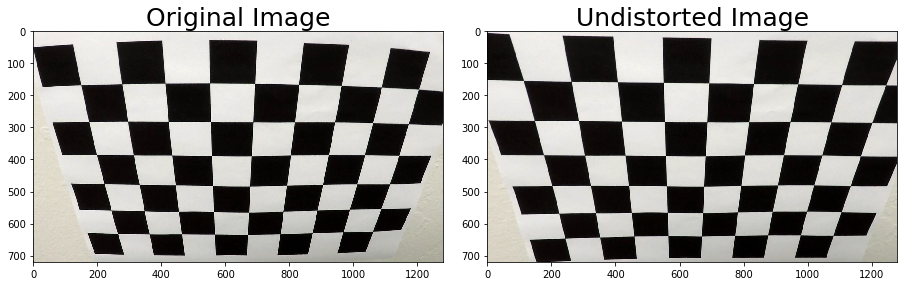

In [13]:
#################################
# Calibrate the camera
##############################

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Read in the images
images = glob.glob('camera_cal\calibration*.jpg')

#test_img = mpimg.imread('calibration2.jpg')
#plt.imshow(test_img)
#plt.show()

# Points used to calibrate the camera
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

nx = 9 # Number of corners in x direction
ny = 6 # Number of corners in y direction

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Cycle through each image gathering points for camera calibration
for fname in images:
    img = mpimg.imread(fname) # read the image into an numpy array
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners are found
    if ret == True:
        # add image points and object points
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# show undistorted images
fname = images[10] #select an original image to display
original_img = mpimg.imread(fname) # read the original image into an numpy array
undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


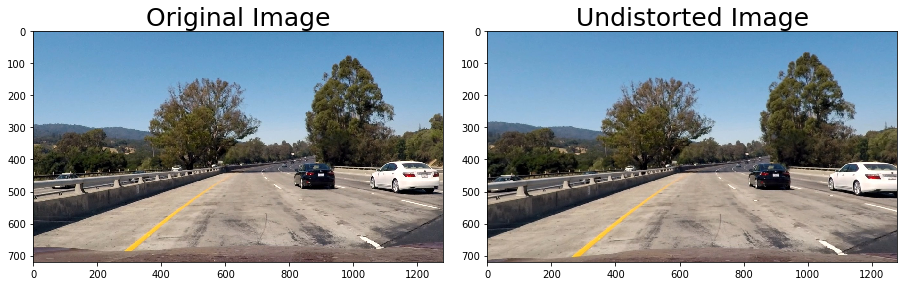

In [15]:
#Apply distortion correction to a road image

fname = 'test_images\\test1.jpg' #select an original image to display
original_img = mpimg.imread(fname) # read the original image into an numpy array
undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [ ]:
#M = cv2.getPerspectiveTransform(src, dst)
#Compute the inverse perspective transform:

#Minv = cv2.getPerspectiveTransform(dst, src)
#Warp an image using the perspective transform, M:

#warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)



In [ ]:
# TODO:
# Won't size images correctly.  Saving to fix later if time.
# show undistorted images
fig, axes = plt.subplots(nrows=len(images), ncols=2)
print(axes.shape)
plt.figure(figsize=(2000,2000))

for i in range(len(images)):
    
    fname = images[i] #select an original image to display
    original_img = mpimg.imread(fname) # read the original image into an numpy array
    undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)

    axes[i,0].imshow(original_img)
    axes[i,0].figure(figsize=(1000,1000))
    axes[i,0].set_title("original")

    axes[i,1].imshow(undistorted_img)
    axes[i,1].figure(figsize=(1000,1000))
    axes[i,1].set_title("undistorted")
    plt.show()
